# Multilevel modelling (or linear mixed effects regression)
 
Multilevel modelling (MLM) is a method of linear regression which accounts for grouped or repeated data. It is commonly used in fields such as psychology where the data from subjects may be organised into nested levels (e.g. students in classrooms) or where subjects are sample repeatedly (e.g. longitudinal studies) and the relationships within these groups or within a participant should be considered. MLMs do this primarily by allowing the regression coefficients to vary for ezch of the groups as well as having regression coefficients which are fixed across the groups.

For one example, say we have a repeated measures study where where participants listen to multiple sound recordings and rate their perception of annoyance each recording. We want to model the relationship between the psychoacoustic features of the sounds to the annoyance rating, but we need to account for the 'base-level' annoyance of each participant. In this setup, we would allow the model intercept (i.e. the general annoyance rating) to vary for each participant while extracting the general relationships between the psychoacoustic features which are fixed across all participants. We then call the participant-level intercepts the random effects and the fixed psychoacoustic coefficients the fixed effects. For this reason, MLMs are also often called mixed-effect models as they mix both the random and fixed effects. This particular type of MLM is called a random-intercept, fixed-slope model.

Another type of MLM is a random-intercept, random-slope model. In this model, both the intercept and the slope of the variables is allowed to vary across the groups. This is the style of model we'll take a look at in this example. Here, we have surve data and corresponding recordings sample from participants in several urban locations. Our goal is to predict the participants' perception of the soundscape of each location, in terms of its pleasantness and eventfulness, based on the psychoacoustic features of the corresponding recordings. We need to consider both the general (fixed) relationship between e.g. sound level and pleasantness, as well as how this relationship may change depending on the context of each individual location. We can imagine that in a street-side location which is dominated by traffic noise, as the sound level increases, the pleasantness will decrease. However, this same relationship may not hold for a park where a water fountain dominates the soundscape. These two locations would therefore have a different slope relating the sound level to the pleasantness. In addition, just like each participant in a repeated measures study may have a different 'base-level' of annoyance, the visual and semantic context of a location may give it a different starting pleasantness, independent of the acoustic features of the space. This is accounted for by allowing the intercept to vary according to the location. Thus, we call this a random-intercept, random-slope model. 

It should be noted that, although we call these location-level effects the 'random effects', unlike the repeated measures model, it's not really correct to call them random. In the repeated-measures case, our goal is to create a model which can work for people not included in the model, so when we move to prediction, we don't include the random effects. Each random intercept is tied to each participant, so by accounting for them in the model building, but not including them in the prediction, we have created a more general model which tells us the relationships which are fixed across the population. However, for this location-based model, our goal is actually to run the prediction on new recordings collected in the same locations, so we want to be able to include the effects specific to that location within our prediction. These effects aren't really 'random', they are helping us account for latent, contextual aspects of the location.

In [2]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from soundscapy import isd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools.sm_exceptions import ConvergenceWarning
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

import numpy as np
import warnings
warnings.simplefilter("ignore", ConvergenceWarning)
%matplotlib inline


## The International Soundscape Database

Our data is publicly available and hosted on Zenodo, so we pull it down directly from there:

In [3]:
# Load SSID dataset.
df = isd.load_isd_dataset(version="v0.2.3").isd.filter_lockdown().isd.validate_dataset(allow_na=True)
print(df.shape)
df.head()

Renaming PAQ columns.
Checking PAQ data quality.
Identified 10 samples to remove.
[124, 146, 160, 178, 226, 381, 689, 839, 1321, 1335]
(1328, 78)


LocationID    SessionID  ... RA_2D_cp(cPa)  PA(Zwicker)
0  CamdenTown  CamdenTown1  ...          14.3    36.019181
1  CamdenTown  CamdenTown1  ...          14.3    36.019181
2  CamdenTown  CamdenTown1  ...          14.3    36.019181
3  CamdenTown  CamdenTown1  ...          14.7    40.523268
4  CamdenTown  CamdenTown1  ...          13.4    27.108635

[5 rows x 78 columns]

Let's take a look at all the locations included in the dataset:

In [4]:
df.LocationID.unique()

array(['CamdenTown', 'EustonTap', 'MarchmontGarden', 'MonumentoGaribaldi',
       'PancrasLock', 'RegentsParkFields', 'RegentsParkJapan',
       'RussellSq', 'SanMarco', 'StPaulsCross', 'StPaulsRow',
       'TateModern', 'TorringtonSq'], dtype=object)

In this dataset, we have 1328 samples of survey responses, paired with acoustic measurement information. This data was collected at 13 locations in London and Venice. At each location, respondents were stopped and asked to fill out a questionnaire on how Pleasant they perceive the soundscape of the location to be. At the same time, a recording was made of what sound they were exposed to. This recording was then analysed to extract the psychoacoustic metrics. The dataset contains:

* `GroupID`:    Group of respondents stopped together (the responses are then averaged across the group)
* `LocationID`: The urban location where the survey was carried out
* `ISOPleasant`:   A soundscape pleasantness rating, from -1 to 1
* `LAeq_L(A)(dB(SPL))`:       Sound level, A-weighted average decibel level during 30-second recording
* `LA10_LA90(dB(SPL))`
* `Loudness_N5(soneGF)`:        Psychoacoustic loudness (sones)
* `N10_N90(soneGF)`
* `Rough_HM_R(asper)`:          Psychoacoustic Roughness (asper)
* `Sharpness_S(acum)`:          Psychoacoustic Sharpness (acum)
* `Ton_HM_Avg,arith(tuHMS)`:        Psychoacoustic Tonality (tuHM)
* `RA_2D_cp(cPA)`
* `PA(Zwicker)`: Psychoacoustic Annoyance

### Objective
Our goal is to use the psychacoustic information to predict how pleasant a person will find the soundscape in a certain location.

<AxesSubplot:>

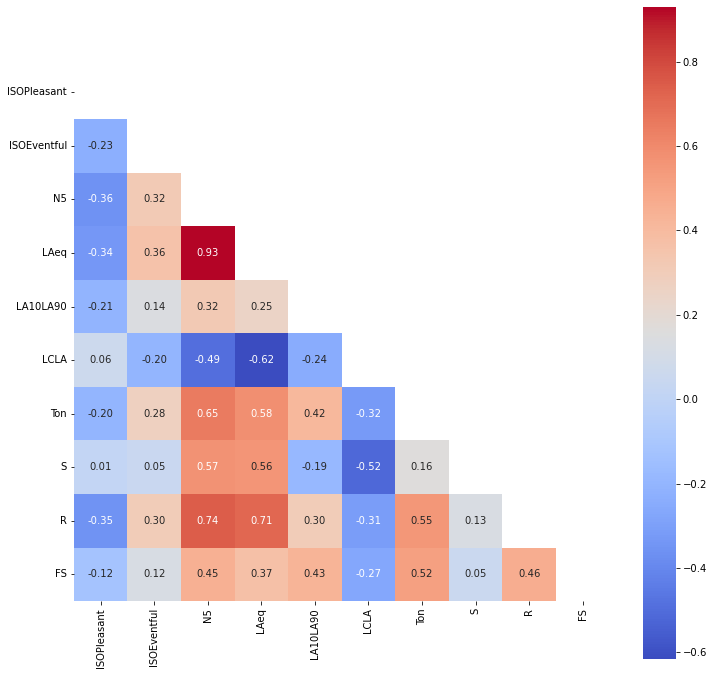

In [5]:
# Cut down the dataset
data = df.rename(columns=
    {'Loudness_N5(soneGF)': 'N5',
    'LAeq_L(A)(dB(SPL))': 'LAeq',
    'LA10_LA90(dB(SPL))': 'LA10LA90',
    'LCeq_LAeq(dB(SPL))': 'LCLA',
    'Ton_HM_Avg,arith(tuHMS)': 'Ton',
    'Rough_HM_R(asper)': 'R',
    'Sharpness_S(acum)': 'S',
    'FS_Avg,arith(vacil)': "FS"
    }
    )

x_feats = ['N5', 'LAeq', 'LA10LA90', 'LCLA', 'Ton', 'S', 'R', 'FS']
data = data[['ISOPleasant', 'ISOEventful', 'N5', 'LAeq', 'LA10LA90', 'LCLA', 'Ton', 'S', 'R', 'FS', 'LocationID']]
data['LocationID'] = data['LocationID'].astype('category')

data = data.dropna()

train, test = train_test_split(data, test_size=0.2, random_state=42, shuffle=True, stratify=data['LocationID'])

# seaborn heatmap version
matrix = np.triu(train.corr(method='pearson'))  # we'll use this to mask half of the symmetrical matrix

fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(train.corr(), annot=True, cmap='coolwarm', fmt='.2f', square=True, ax=ax, mask=matrix)

/opt/miniconda3/envs/pymer4/lib/python3.9/site-packages/seaborn/regression.py:592: UserWarning: sharex is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


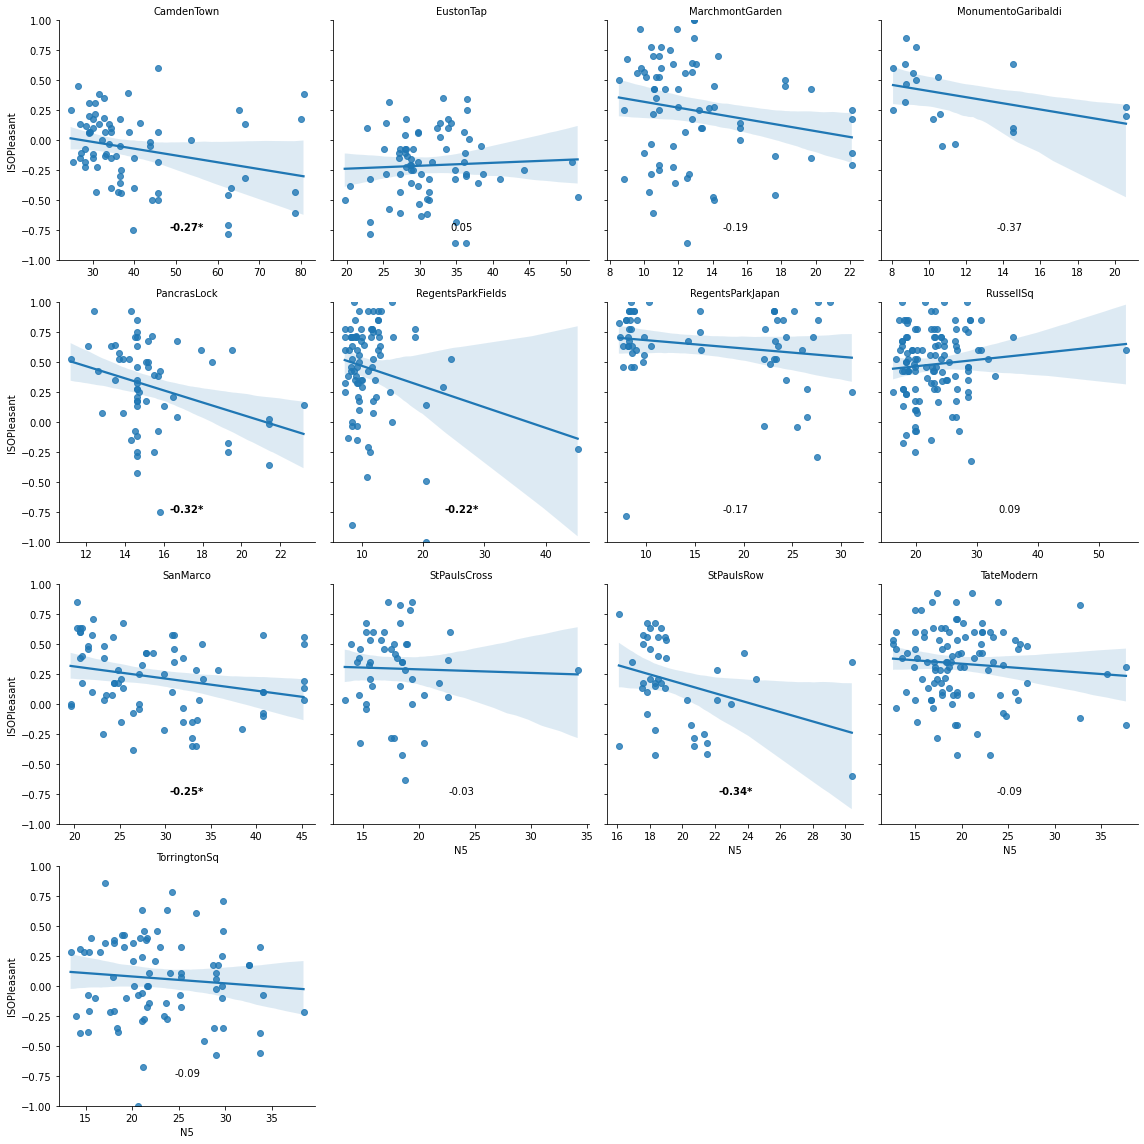

In [6]:
# You don't need to replicate this!
from scipy.stats import pearsonr

ordered_locations = sorted(set(train.LocationID))

# Plotting the relationships by location to see how the relationships change
def location_lmplots(data, x, y, groups, group_order, ylim=(-1,1), xlim=None, order=1):
    grid = sns.lmplot(x = x, y = y, col = groups, order=order, sharex = False, col_wrap = 4, col_order=group_order, data = data, height=4)
    grid.set(ylim=ylim)
    grid.set(xlim=xlim)
    for location,ax in zip(group_order, grid.axes.ravel()):
        df = data.loc[data[groups]==location, [y, x]].dropna()
        r,p = pearsonr(df[y], df[x])
        if p < 0.01: symb='**'
        elif p < 0.05: symb='*'
        else: symb="" 
        fontweight = 750 if p < 0.05 else None

        text = f"{round(r, 2)}{symb}"
        ax.text(np.mean(ax.get_xlim()), min(ax.get_ylim())*.75, text, ha="center", fontweight=fontweight)
    grid.set_titles("{col_name}")  # use this argument literally

    return grid

location_lmplots(train, 'N5', 'ISOPleasant', 'LocationID', ordered_locations)

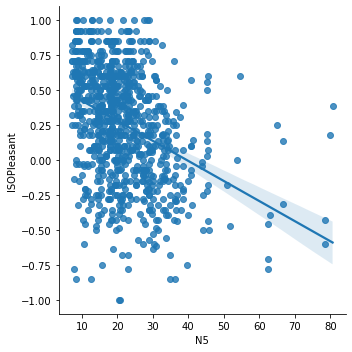

In [7]:
sns.lmplot(x="N5", y="ISOPleasant", data=train)

/opt/miniconda3/envs/pymer4/lib/python3.9/site-packages/seaborn/regression.py:592: UserWarning: sharex is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


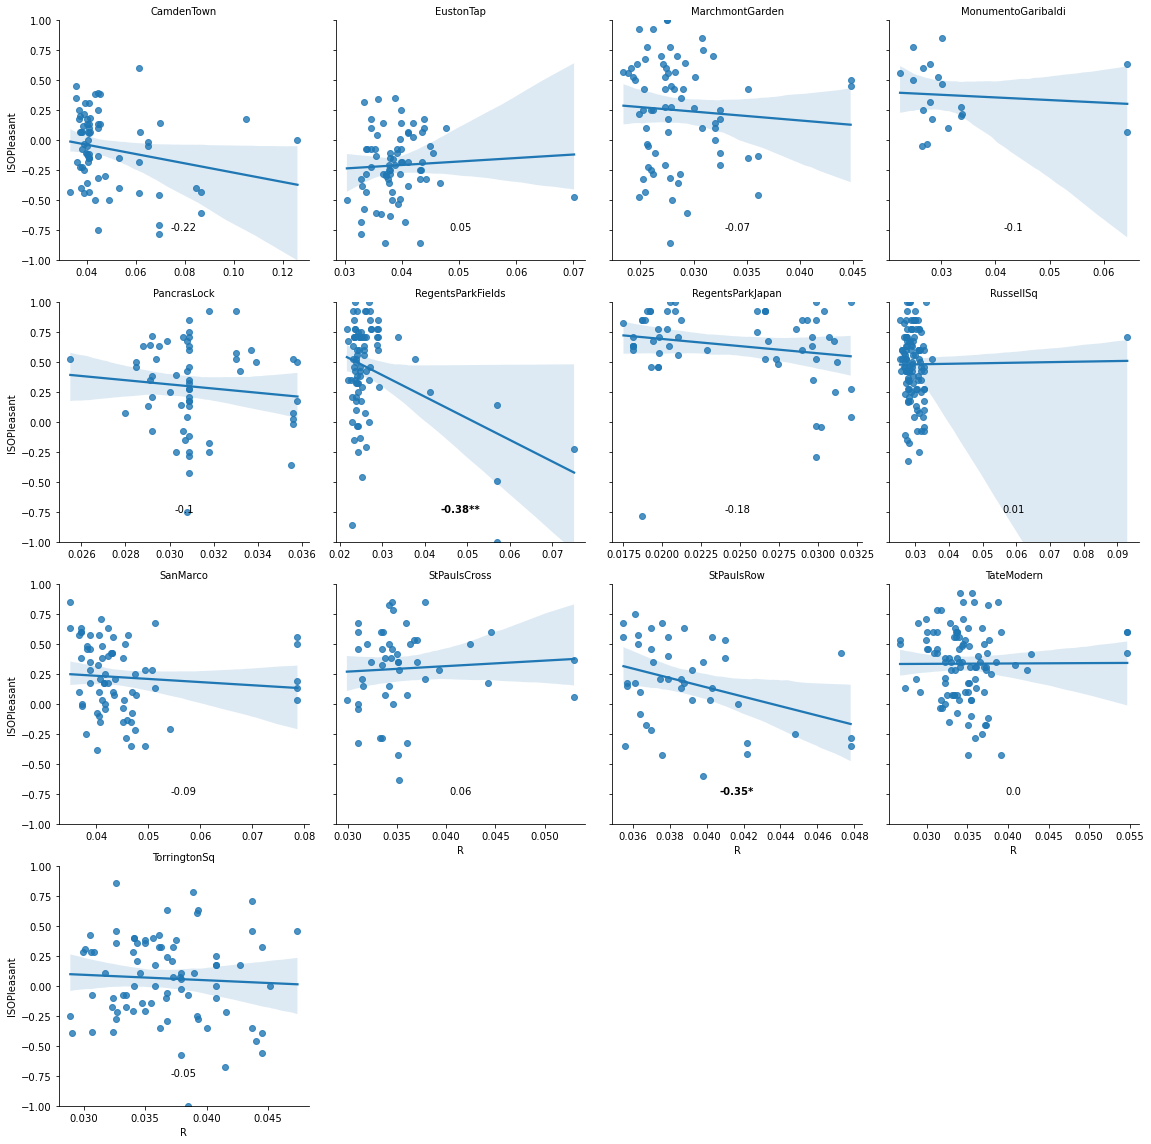

In [8]:
location_lmplots(train, 'R', 'ISOPleasant', 'LocationID', ordered_locations)

## Now for the models!

### First, scale the data

In [9]:
# Normalise the data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train[['N5', 'LAeq', 'LA10LA90', 'LCLA', 'Ton', 'FS', 'S', 'R']] = scaler.fit_transform(train[['N5', 'LAeq', 'LA10LA90', 'LCLA', 'Ton', 'FS', 'S', 'R']])
train.head()

test[['N5', 'LAeq', 'LA10LA90', 'LCLA', 'Ton', 'FS', 'S', 'R']] = scaler.transform(test[['N5', 'LAeq', 'LA10LA90', 'LCLA', 'Ton', 'FS', 'S', 'R']])
test.head()

ISOPleasant  ISOEventful        N5  ...         R        FS       LocationID
1795       0.4571       0.3107  0.356551  ...  0.007453 -0.673247     TorringtonSq
234        0.0000       0.1464  1.200605  ...  0.917672 -0.396321        EustonTap
1382       0.5303       0.0303 -0.467874  ... -0.111271 -0.538857     StPaulsCross
383        0.0732       0.0303 -0.330470  ...  1.016609 -0.325053  MarchmontGarden
1560       0.5303       0.3839  0.287849  ... -0.081590  0.565795       TateModern

[5 rows x 11 columns]

Since our ultimate goal is to predict the overall soundscape of a location, not of individuals, we define a function to help us score the success of the model.

In [10]:
def location_r2(response, data, group="LocationID"):
    y = data.loc[:,[response, "fits", group]]
    y_loc = y.groupby(group).mean()
    return round(r2_score(y_loc[response], y_loc['fits']), 3)

## MLM in Pymer4

Multilevel modelling is unfortunately not very good in Python. Technically, statsmodels has a method for it, but this is limited and occassionally gives some weird results. This original modelling was done in `R` using its `lme4` library. Thankfully, there are some interesting methods for interfacing Python with R so you can make use of R's statistics powers from the comfort of Python. The most flexible of these is `rpy2` which allows you to directly pass Python objects into and out of an R cell and write straight R code in between. 

Luckily there is also a python package specifically for making use of R's `lme4` multi level modelling library, directly from python. We don't need to pass objects or write R code! 

#### Predicting pleasantness

First, we'll try out a standard multiple linear regression with `ISOPleasant` as the outcome and the psychoacoustic features as the inputs just to see how well that does.

Formula: ISOPleasant~N5+LAeq+LA10LA90+LCLA

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 900	 R^2: 0.173	 R^2_adj: 0.169

Log-likelihood: -373.641 	 AIC: 757.281	 BIC: 781.293

Fixed effects:



<AxesSubplot:xlabel='fits', ylabel='ISOPleasant'>

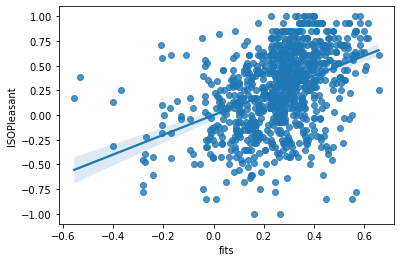

In [11]:
from pymer4.models import Lm

model = Lm("ISOPleasant ~ N5 + LAeq + LA10LA90 + LCLA", data=train)
model.fit(REML=False)
sns.regplot(x='fits', y='ISOPleasant', data=model.data, fit_reg=True)

<AxesSubplot:xlabel='fits', ylabel='ISOPleasant'>

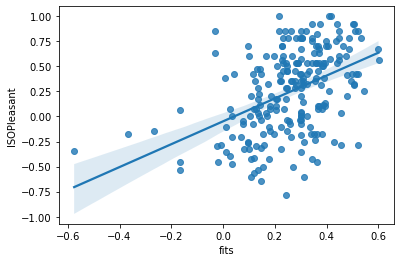

In [12]:
test['fits'] = model.predict(test)
sns.regplot(x='fits', y='ISOPleasant', data=test, fit_reg=True)

In [13]:
print("Train R2: ", location_r2("ISOPleasant", model.data))
print("Test  R2 : ", location_r2("ISOPleasant", test))


Train R2:  0.605
Test  R2 :  0.51


#### Now as a MultiLevel Model which accounts for the Location

boundary (singular) fit: see ?isSingular 

Formula: ISOPleasant~1+N5+(1+LAeq+LA10LA90+LCLA|LocationID)

Family: gaussian	 Inference: parametric

Number of observations: 900	 Groups: {'LocationID': 13.0}

Log-likelihood: -298.969 	 AIC: 623.939

Random effects:

                   Name    Var    Std
LocationID  (Intercept)  0.024  0.156
LocationID         LAeq  0.014  0.119
LocationID     LA10LA90  0.003  0.052
LocationID         LCLA  0.004  0.064
Residual                 0.108  0.328

                    IV1       IV2   Corr
LocationID  (Intercept)      LAeq  0.098
LocationID  (Intercept)  LA10LA90 -0.471
LocationID  (Intercept)      LCLA -0.362
LocationID         LAeq  LA10LA90 -0.924
LocationID         LAeq      LCLA  0.892
LocationID     LA10LA90      LCLA -0.652

Fixed effects:



<AxesSubplot:xlabel='Estimate'>

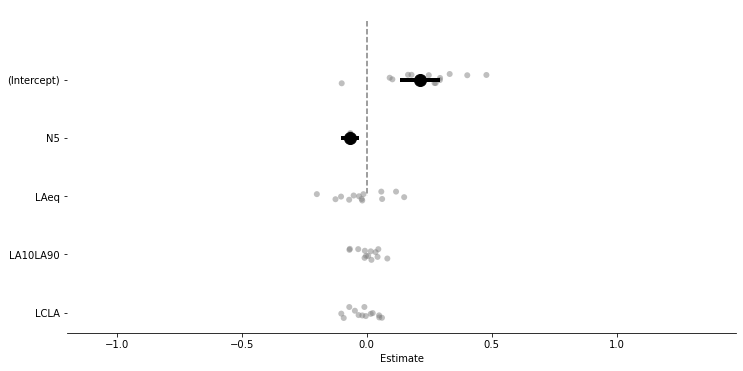

In [14]:
from pymer4.models import Lmer

model = Lmer("ISOPleasant ~ 1 + N5 + (1 + LAeq + LA10LA90 + LCLA | LocationID)", data=train)
model.fit(REML=False)
model.plot_summary()

In [15]:
r_mod = model.model_obj

In [16]:
# packnames = ("lmerTest", "MuMIn")

# from rpy2.robjects.packages import importr
# from rpy2.robjects.vectors import StrVector
# utils = importr('utils')
# utils.chooseCRANmirror(ind=1)
# utils.install_packages(StrVector(packnames))

In [17]:
%%R -i r_mod
r2 <- MuMIn::r.squaredGLMM(r_mod)
print(r2)

UsageError: Cell magic `%%R` not found.


<AxesSubplot:xlabel='fits', ylabel='ISOPleasant'>

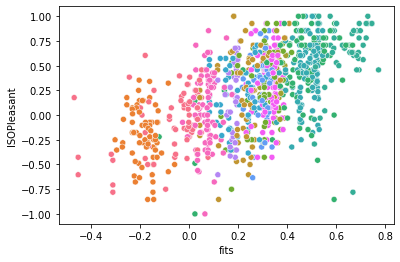

In [18]:
sns.scatterplot(data=model.data, x='fits', y='ISOPleasant', hue='LocationID', legend=False)

<AxesSubplot:xlabel='fits', ylabel='ISOPleasant'>

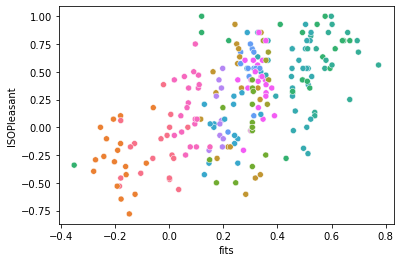

In [19]:
test['fits'] = model.predict(test, verify_predictions=False, use_rfx=True, pred_type='link')
sns.scatterplot(data=test, x='fits', y='ISOPleasant', hue='LocationID', legend=False)

In [20]:
model.coefs

Estimate    2.5_ci   97.5_ci  ...    T-stat     P-val  Sig
(Intercept)  0.213659  0.133666  0.293652  ...  5.235005  0.001043   **
N5          -0.065582 -0.101975 -0.029190  ... -3.532020  0.000788  ***

[2 rows x 8 columns]

In [21]:
model.ranef

X.Intercept.      LAeq  LA10LA90      LCLA
CamdenTown             -0.121677 -0.052268  0.035468 -0.003658
EustonTap              -0.313570 -0.017786  0.046522  0.049707
MarchmontGarden         0.079028  0.149942 -0.067540  0.061072
MonumentoGaribaldi      0.057691 -0.013094 -0.002280 -0.017427
PancrasLock             0.034685 -0.124743  0.043468 -0.069617
RegentsParkFields      -0.048252 -0.199339  0.082603 -0.091821
RegentsParkJapan        0.265178 -0.102579  0.005786 -0.101553
RussellSq               0.188637  0.117429 -0.068950  0.024090
SanMarco                0.062318 -0.070113  0.019017 -0.047139
StPaulsCross            0.079839  0.061789 -0.033824  0.016309
StPaulsRow             -0.034386 -0.030872  0.016200 -0.009183
TateModern              0.118262 -0.020081 -0.007268 -0.032303
TorringtonSq           -0.110882  0.058470 -0.008400  0.050342

In [22]:
print("Train R2: ", location_r2("ISOPleasant", model.data, group="LocationID"))
print("Test  R2: ", location_r2("ISOPleasant", test))

Train R2:  0.997
Test  R2:  0.76


## ISOEventful Model

Turns out, the model for predicting eventfulness didn't actually need to be an MLM. We discovered this through our initial feature selection. This finding on its own was important, suggesting that, while the perception of pleasantness is dependent on the context provided by the location, the perception of eventfulness is driven mostly be the acoustic features!

Formula: ISOEventful~1+S+FS+Ton+LAeq+LCLA

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 900	 R^2: 0.171	 R^2_adj: 0.166

Log-likelihood: -181.372 	 AIC: 374.744	 BIC: 403.558

Fixed effects:



<AxesSubplot:xlabel='fits', ylabel='ISOEventful'>

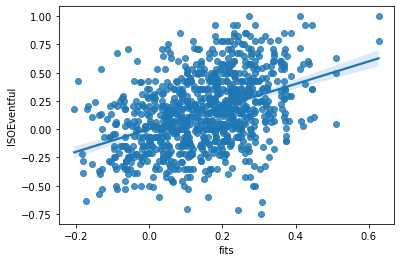

In [ ]:
from pymer4.models import Lm

model = Lm("ISOEventful ~ 1 + S + FS + Ton + LAeq + LCLA", data=train)
model.fit(REML=False)
sns.regplot(x='fits', y='ISOEventful', data=model.data, fit_reg=True)

<AxesSubplot:xlabel='fits', ylabel='ISOEventful'>

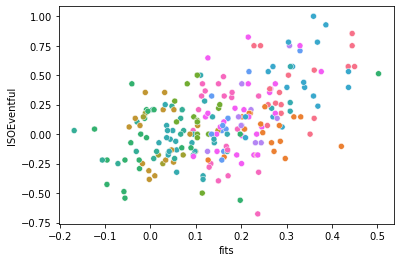

In [ ]:
test['fits'] = model.predict(test)
sns.scatterplot(data=test, x='fits', y='ISOEventful', hue='LocationID', legend=False)

In [ ]:
print("Train R2: ", location_r2("ISOEventful", model.data))
print("Test R2 : ", location_r2("ISOEventful", test))


Train R2:  0.844
Test R2 :  0.601


## Random Intercept Model


ISOPleasant ~ N5
          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: ISOPleasant
No. Observations: 900     Method:             REML       
No. Groups:       13      Scale:              0.1116     
Min. group size:  19      Log-Likelihood:     -314.3232  
Max. group size:  117     Converged:          Yes        
Mean group size:  69.2                                   
---------------------------------------------------------
               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------
Intercept       0.249    0.053  4.691 0.000  0.145  0.353
N5             -0.077    0.017 -4.460 0.000 -0.111 -0.043
LocationID Var  0.035    0.045                           

R-sq:  0.10202661892159448
AIC:   nan
BIC:   nan
{'CamdenTown': LocationID   -0.170358
dtype: float64, 'EustonTap': LocationID   -0.366677
dtype: float64, 'MarchmontGarden': LocationID   -0.060786
dtype: float64, 'MonumentoGaribaldi': Loc

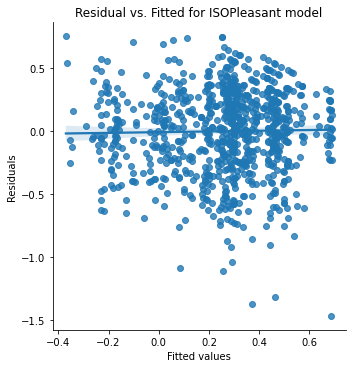

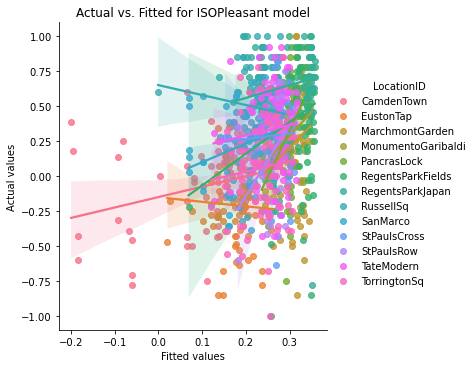

R-sq:  0.10202661892159448
Location R-sq:  0.3165185300435218


In [ ]:
# Define the fixed effects formula
formula = "ISOPleasant ~ N5"

# Initiate model
model = smf.mixedlm(formula, train, groups='LocationID', re_formula=None)
model_fit = model.fit()

# Summarise the model
def model_r2(model_fit, data):
    response = model_fit.model.formula.split()[0]
    y = data[response]
    y_predict = model_fit.predict(data)
    return r2_score(y, y_predict)

def location_r2(model_fit, data, group="LocationID"):
    response = model_fit.model.formula.split()[0]
    y = data.loc[:,[response, group]]
    y['predict'] = model_fit.predict(data)
    y_loc = y.groupby(group).mean()
    return r2_score(y_loc[response], y_loc['predict'])

def summarise_model(model_fit, data, group=None):
    response = 'ISOPleasant'
    
    print(model_fit.model.formula)
    print(model_fit.summary())
    print("R-sq: ", model_r2(model_fit, data))
    print("AIC:  ", model_fit.aic)
    print("BIC:  ", model_fit.bic)
    print(model_fit.random_effects)
    
    performance = pd.DataFrame()
    performance["actual"] = data.loc[:, response]
    performance["predicted"] = model_fit.predict(data)
    if group:
        performance[group] = data.loc[:, group]
    # performance["fitted"] = model_fit.fittedvalues

    resid_data = pd.DataFrame({'residuals': model_fit.resid.values, 'fitted': model_fit.fittedvalues})
    sns.lmplot(x='fitted', y='residuals', data=resid_data)
    plt.title(f"Residual vs. Fitted for {response} model")
    plt.xlabel("Fitted values")
    plt.ylabel("Residuals")
    plt.show()

    sns.lmplot(x="predicted", y="actual", data=performance, fit_reg=True, hue=group)
    plt.title(f"Actual vs. Fitted for {response} model")
    plt.xlabel("Fitted values")
    plt.ylabel("Actual values")
    plt.show()

    print("R-sq: ", model_r2(model_fit, data))
    print("Location R-sq: ", location_r2(model_fit, data))
    
    return performance

train_perf = summarise_model(model_fit, train, group='LocationID')
# test_perf = summarise_model(model_fit, test)

## RandomForestRegressor multioutput

Just out of interest, I thought it would be interesting to see how another algorithm might perform for this data. Decision trees (and by extension Random Forests) seem like a reasonable choice since we have many perceptual things which may depend on some threshold and the locatiion effects can easiy work in a decision tree.

In [23]:
x_feats = ['N5', 'LAeq', 'LA10LA90', 'LCLA', 'Ton', 'S', 'R', 'FS']
features = x_feats
X_train = train[features]
X_test = test[features]

For sklearn models, we need to convert our categorical feature (`LocationID`) using one-hot encoding.

In [24]:
from sklearn.preprocessing import OneHotEncoder

def onehot_locationID(df, X):
    enc = OneHotEncoder()
    transformed = enc.fit_transform(df[['LocationID']])
    X[enc.categories_[0]] = transformed.toarray()
    return X

X_train = onehot_locationID(train, X_train)
X_test = onehot_locationID(test, X_test)

/opt/miniconda3/envs/pymer4/lib/python3.9/site-packages/pandas/core/indexing.py:659: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[k] = np.nan
/opt/miniconda3/envs/pymer4/lib/python3.9/site-packages/pandas/core/indexing.py:659: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[k] = np.nan


In [25]:
X_train


N5      LAeq  LA10LA90  ...  StPaulsRow  TateModern  TorringtonSq
391  -1.046935 -1.422115 -0.358502  ...         0.0         0.0           0.0
931  -1.342353 -1.977071 -1.076169  ...         0.0         0.0           0.0
1285  2.319467  1.991011  1.169743  ...         0.0         0.0           0.0
218   0.915982  1.021994 -0.454618  ...         0.0         0.0           0.0
1120 -0.212695 -0.185684 -0.784617  ...         0.0         0.0           0.0
...        ...       ...       ...  ...         ...         ...           ...
1652 -0.732868 -0.655815 -0.323260  ...         0.0         1.0           0.0
1751  0.111186  0.214000  0.919842  ...         0.0         0.0           1.0
193   0.837465  0.908414 -0.217532  ...         0.0         0.0           0.0
815  -1.135266 -1.432179 -0.332871  ...         0.0         0.0           0.0
777  -0.654351 -0.936169  0.929453  ...         0.0         0.0           0.0

[900 rows x 21 columns]

In [26]:
y_train = train[["ISOPleasant", "ISOEventful"]]
y_test = test[["ISOPleasant", "ISOEventful"]]


In [27]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

tuned_parameters = {'n_estimators': [500, 700, 1000, 1250], 'max_depth': [None, 1, 2, 3, 4, 5], 'min_samples_split': [2, 3], 'random_state': [42]}

clf = GridSearchCV(RandomForestRegressor(), tuned_parameters, cv=5, n_jobs=-1, verbose=1)
clf.fit(X_train, y_train)
clf.best_estimator_

Fitting 5 folds for each of 48 candidates, totalling 240 fits


RandomForestRegressor(max_depth=5, n_estimators=1250, random_state=42)

Train R2:  0.953


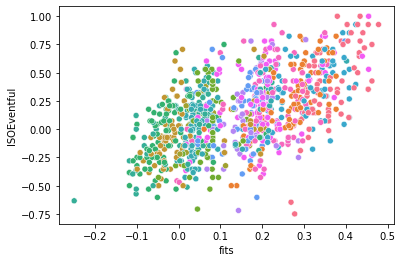

In [28]:
fits = clf.best_estimator_.predict(X_train)

train['fits'] = fits[:,1]
sns.scatterplot(x='fits', y='ISOEventful', data=train, hue='LocationID', legend=False)
print("Train R2: ", location_r2("ISOEventful", train))

Test  R2:  0.574


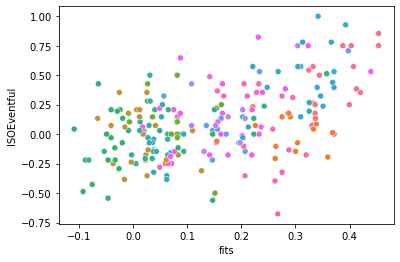

In [ ]:
fits = clf.best_estimator_.predict(X_test)
test['fits'] = fits[:,1]
sns.scatterplot(x='fits', y='ISOEventful', data=test, hue='LocationID', legend=False)
print("Test  R2: ", location_r2("ISOEventful", test))

<AxesSubplot:xlabel='ISOPleasant', ylabel='ISOEventful'>

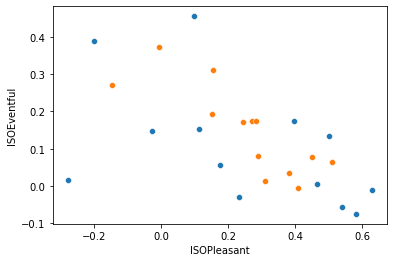

In [ ]:
plots = y_test.copy()
plots[['pred_ISOPl', 'pred_ISOEv']] = fits
plots['LocationID'] = test['LocationID']
plots = plots.groupby('LocationID').mean()
sns.scatterplot(data=plots, x='ISOPleasant', y='ISOEventful')
sns.scatterplot(data=plots, x='pred_ISOPl', y='pred_ISOEv')

In [ ]:
feat_imp = pd.DataFrame({'features': clf.best_estimator_.feature_names_in_, 'vals': clf.best_estimator_.feature_importances_})
feat_imp.sort_values('vals', ascending=False)

features      vals
6                    R  0.425521
5                    S  0.122163
0                   N5  0.098436
4                  Ton  0.057440
2             LA10LA90  0.056471
3                 LCLA  0.054898
7                   FS  0.046147
9            EustonTap  0.044099
1                 LAeq  0.031351
8           CamdenTown  0.010387
14    RegentsParkJapan  0.009855
10     MarchmontGarden  0.009552
20        TorringtonSq  0.008820
15           RussellSq  0.006609
13   RegentsParkFields  0.006035
19          TateModern  0.003607
12         PancrasLock  0.002860
16            SanMarco  0.002499
18          StPaulsRow  0.002032
17        StPaulsCross  0.001045
11  MonumentoGaribaldi  0.000170

In [ ]:
clf.best_estimator_.score(X_train, y_train)

0.38138700146059984

In [ ]:
clf.best_estimator_.score(X_test, y_test)

0.284552129967855

### Visualise the trees


In [ ]:
model = clf.best_estimator_
estimator = model.estimators_[5]

In [ ]:
from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = X_train.columns,
                class_names = y_train.columns,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.774945 to fit


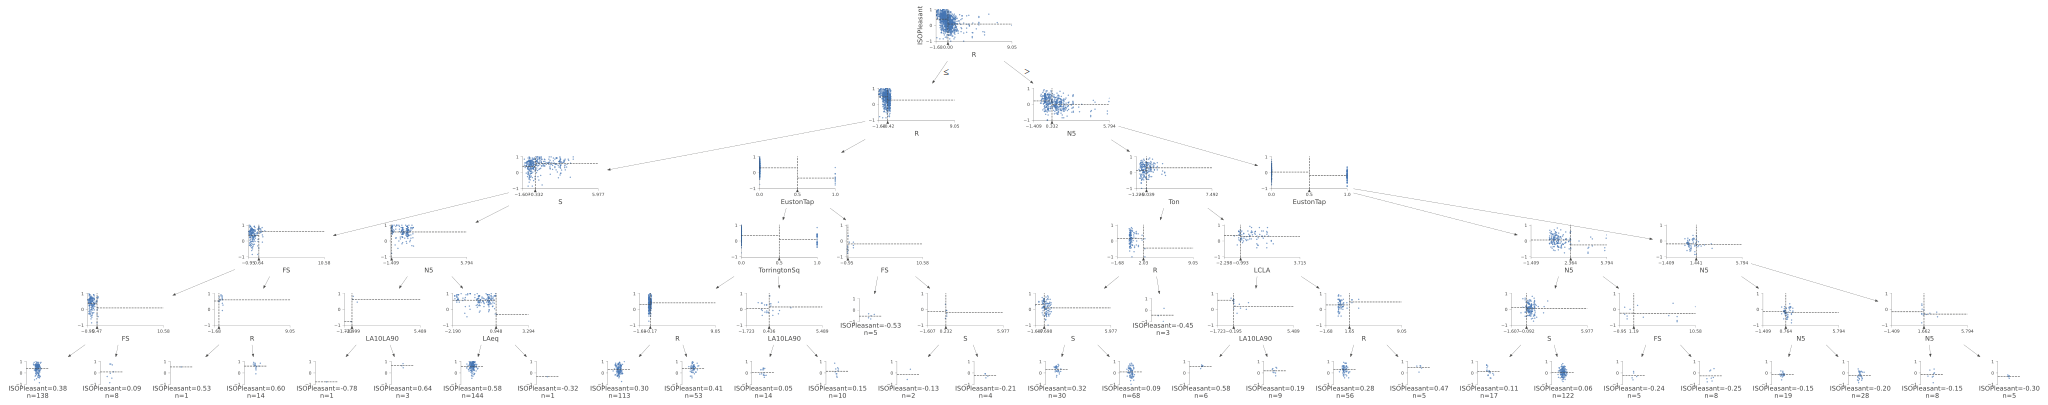

In [ ]:
from dtreeviz.trees import dtreeviz

viz = dtreeviz(estimator, X_train.values, y_train['ISOPleasant'].values, target_name='ISOPleasant', feature_names=X_train.columns)
viz